In [1]:
!pip install py4j

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from pyspark import SparkConf, SparkContext, SQLContext

In [3]:
# Configure spark context settings and initialize SQL context
conf = (SparkConf()
         .setAppName("s3a_test")
         .set("spark.executor.instances", "8")
         .set("spark.executor.cores", 2)
         .set("spark.shuffle.compress", "true")
         .set("spark.io.compression.codec", "snappy")
         .set("spark.executor.memory", "2g"))

sc = SparkContext(conf = conf)

sqlContext = SQLContext(sc)

## Load Data, Manage Format for Regression

In [65]:
# READ DATA FILE
df = sqlContext.read.load("training.json")

In [66]:
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



In [68]:
df.count()

4230796

In [73]:
# Work on random sample of the data
data = df.sample(False, 0.002, seed=None)

In [74]:
data.count()

8243

## Split Training and Testing

In [75]:
training, testing = data.randomSplit([0.7, 0.3])

In [76]:
import numpy as np

# Convert to numpy array
X_train = np.array(training.select('features').collect()).squeeze()
y_train = np.array(training.select('label').collect()).squeeze()
X_test = np.array(testing.select('features').collect()).squeeze()
y_test = np.array(testing.select('label').collect()).squeeze()

# Drop last column from X_train and X_test - this column accidentally contains the label
X_train = X_train[:,0:-1]
X_test = X_test[:,0:-1]

## Multinomial Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression

# Initialize Model
lr = LogisticRegression()

# Fit training data
model = lr.fit(X_train, y_train)

# Predict labels on test data
preds = model.predict(X_test)

[]

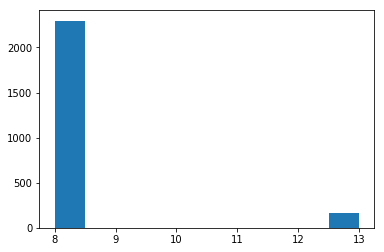

In [127]:
import matplotlib.pyplot as plt
plt.hist(preds)
plt.plot()

In [99]:
from sklearn.model_selection import GridSearchCV
lr_params = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']} #, 'penalty':['l1','l2']}
lr = LogisticRegression()
clf = GridSearchCV(lr, lr_params)

In [100]:
clf.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not 

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [104]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [109]:
clf.cv_results_['rank_test_score']

array([1, 4, 5, 2, 2], dtype=int32)

In [103]:
lr_params

{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

## Random Forest

In [157]:
from sklearn import tree

decTree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
model = decTree.fit(X_train, y_train)
pred = model.predict(X_test)

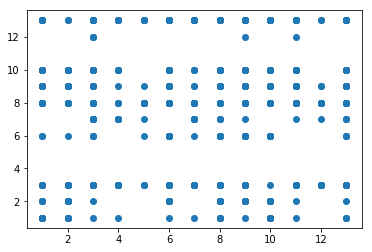

In [158]:
plt.scatter(y_test,pred)

In [160]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(n_estimators=100, verbose=1)

model = RFC.fit(X_train, y_train)

pred = model.predict(X_test)

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


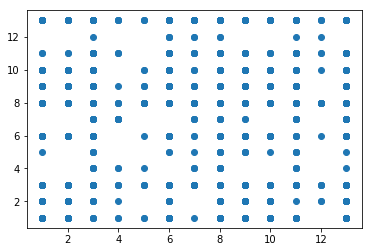

In [161]:
plt.scatter(y_test, pred)

In [165]:
num_correct = np.sum(y_test == pred)

In [171]:
accuracy = num_correct / X_test.shape[0]
print(accuracy)

In [247]:
# Exhaustive Hyperparameter Search
rfc_params = {'n_estimators':[10, 25, 50, 100], 'min_samples_split':[20, 50, 75, 100, 150]}
rfc = RandomForestClassifier()
rfc_search = GridSearchCV(rfc, rfc_params)

In [248]:
rfc_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 100], 'min_samples_split': [20, 50, 75, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [249]:
rfc_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [250]:
rfc_search.cv_results_['params']

[{'min_samples_split': 20, 'n_estimators': 10},
 {'min_samples_split': 20, 'n_estimators': 25},
 {'min_samples_split': 20, 'n_estimators': 50},
 {'min_samples_split': 20, 'n_estimators': 100},
 {'min_samples_split': 50, 'n_estimators': 10},
 {'min_samples_split': 50, 'n_estimators': 25},
 {'min_samples_split': 50, 'n_estimators': 50},
 {'min_samples_split': 50, 'n_estimators': 100},
 {'min_samples_split': 75, 'n_estimators': 10},
 {'min_samples_split': 75, 'n_estimators': 25},
 {'min_samples_split': 75, 'n_estimators': 50},
 {'min_samples_split': 75, 'n_estimators': 100},
 {'min_samples_split': 100, 'n_estimators': 10},
 {'min_samples_split': 100, 'n_estimators': 25},
 {'min_samples_split': 100, 'n_estimators': 50},
 {'min_samples_split': 100, 'n_estimators': 100},
 {'min_samples_split': 150, 'n_estimators': 10},
 {'min_samples_split': 150, 'n_estimators': 25},
 {'min_samples_split': 150, 'n_estimators': 50},
 {'min_samples_split': 150, 'n_estimators': 100}]

In [251]:
rfc_search.cv_results_['mean_fit_time']

array([ 0.13553294,  0.24190505,  0.45436819,  0.80057081,  0.09496919,
        0.20613098,  0.35737658,  0.73546688,  0.07693052,  0.18027854,
        0.34263754,  0.65958397,  0.07906167,  0.1673224 ,  0.33883103,
        0.62534499,  0.07763974,  0.16877087,  0.30832307,  0.58872859])

In [252]:
rfc_search.cv_results_['mean_score_time']

array([ 0.01171859,  0.02339562,  0.04197915,  0.06382926,  0.00848516,
        0.0188996 ,  0.03450092,  0.06774155,  0.01009703,  0.01824252,
        0.02861547,  0.06353704,  0.00760444,  0.0153269 ,  0.03024284,
        0.06196189,  0.00721081,  0.01545509,  0.0261995 ,  0.05601684])

In [253]:
rfc_search.cv_results_['mean_test_score']

array([ 0.26081689,  0.27033576,  0.27466251,  0.27379716,  0.27466251,
        0.28106611,  0.27847006,  0.28210453,  0.27500865,  0.2805469 ,
        0.28245067,  0.28158532,  0.28123918,  0.28020076,  0.28071997,
        0.28158532,  0.27829699,  0.28331603,  0.27950848,  0.28020076])

<Container object of 20 artists>

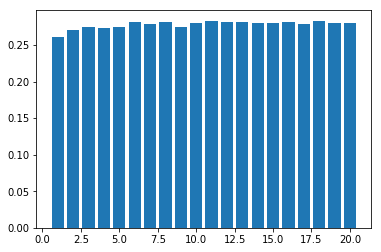

In [259]:
plt.bar(np.array(range(1,len(rfc_search.cv_results_['params'])+1)),rfc_search.cv_results_['mean_test_score'])

In [258]:
len(rfc_search.cv_results_['params'])

20

## Boosting